In [ ]:
# Instalación forzada
!pip install --upgrade google-cloud-bigquery google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00


In [ ]:
# Autenticación y Configuración

from google.colab import auth
from google.cloud import bigquery
import os

# 1. Autenticación
auth.authenticate_user()

# 2. Definición del ID del proyecto
PROJECT_ID = 'sincere-cortex-467814-j3'

# 3. Configuración del cliente (Necesario para ejecutar SQL con Python)
client = bigquery.Client(project=PROJECT_ID)

# 4. Definir el entorno
os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID

# **Análisis de datos del E-Commerce**




## **1. Resumen del Proyecto**
Este proyecto es un análisis integral del rendimiento y la logística del e-commerce brasileño Olist (2016-2018), utilizando un enfoque de Data Analyst centrado en la rentabilidad y la experiencia del cliente.

La meta de este pipeline de análisis es transformar datos brutos de la base de datos relacional de Olist en insights accionables, demostrando la capacidad de manejar grandes volúmenes de datos desde la ingesta hasta la visualización.

## **2. Problema empresarial**
La gerencia de Olist necesita identificar y priorizar las palancas de crecimiento más efectivas para el negocio.
Específicamente, se requiere un análisis que permita:

  * Evaluar el rendimiento histórico (2016-2018) para determinar las categorías de productos más rentables y las de peor desempeño, analizando su evolución trimestral y su impacto en el ingreso total.
  
  * Cuantificar la relación entre la experiencia del cliente (Puntuación de Reseñas) y la eficiencia logística (Tiempos de entrega).
  

El objetivo es dirigir las inversiones a las categorías de alto potencial y mitigar los riesgos logísticos que afectan la satisfacción del cliente.

## **3. Fase de preparación (ETL)**
En este apartado se detallará todo el proceso de ETL de proyecto, se va a utilizar la herramienta BigQuery cuyo lenguaje es SQL para hacer consultas y modificaciones en el dataset con el objetivo de clasificar los datos por tablas de hechos y tablas de dimensiones.

### **3.1 Obtención del dataset**
El dataset ha sido descargado de Kaggle y subido a BigQuery.

Durante el proceso ha ocurrido un error al subir una de las tablas, el cual se ha corregido permitiendo que BigQuery procese 2000 errores además de evitar que los datos entrcomillados de cada celda se salten de línea: 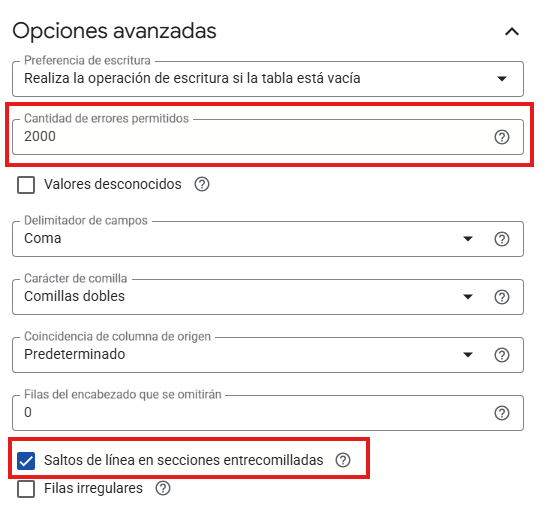

### **3.2 Identificación de las Tablas de Hechos y Tablas de Dimensiones**
Una vez subidas todas las tablas, se ha procedido a averiguar cuáles son las claves primarias y la cardinalidad de las mismas para distinguir las Tablas de Hechos y las Tablas de Dimensiones, procedimiento crucial para el futuro modelado y la visualización en profundidad con Power BI.

Para este paso se han visto las definiciones de cada clave al origen de los datos (Kaggle):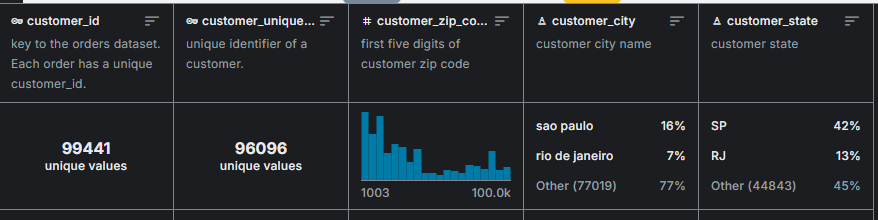


**Razonamiento y Validación Técnica**

1. Tablas de Dimensión: Se confirmó que las tablas con atributos descriptivos(customers, products, sellers) tienen una clave principal única (ej: customer_id en customers).
2. Tablas de Hechos: El objetivo de medición se centró en price y freight_value. Se descartó la tabla orders (con clave order_id única) por carecer de estas métricas transaccionales.
3. Confirmación de la Tabla de Hechos principal: La tabla order_items contiene las métricas, y su clave de orden se repite, lo que establece su nivel de detalle en el ítem de venta.

**Validación SQL de la Cardinalidad:**
```
-- Conteo de ítems totales (filas totales, nivel de detalle del Fact Table)
SELECT COUNT(order_id) FROM order_items_dataset;
-- Resultado: 112,650

-- Conteo de órdenes únicas (pedidos únicos)
SELECT COUNT(DISTINCT order_id) FROM order_items_dataset;
-- Resultado: 98,666
```

La diferencia confirma que order_items_dataset registra múltiples líneas de venta por cada orden, estableciéndola como el nivel de detalle granular para la Tabla de Hechos principal (fact_sales).


**Tablas de Hechos y Dimensiones Definidas**

- HECHOS (Principal): es la tabla order_items, es la 	base para calcular las ventas (precio, flete).
- HECHOS (Observación):	es la order_reviews, es la	base para medir la satisfacción (review_score).
- DIMENSIÓN:	es la tabla orders, relativa a atributos temporales (fechas y estados de la orden).
- DIMENSIÓN:	tabla customers,	referente a atributos geográficos del cliente.
- DIMENSIÓN:	tabla products + translation	referente a atributos descriptivos del producto (categoría).

### **3.3 Construcción de la Tabla Maestra (fact_sales)**
La siguiente sección contiene el código SQL final ejecutado en BigQuery para construir la tabla fact_sales. Esta consulta unifica las métricas de la Tabla de Hechos con todas las dimensiones clave mediante una secuencia de INNER JOINs y LEFT JOINs.
Su objetivo es posibilitar la unificación y relación de las tablas, con el fin de poder hacer un análisis eficaz y del que se pueda obtener información de valor.

In [ ]:
# Construcción de la tabla de hechos principal fact_sales

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.fact_sales AS
SELECT
    orders.order_id,
    order_items.order_item_id,
    products.product_id,
    sellers.seller_id,
    customers.customer_unique_id,
    order_items.price,
    order_items.freight_value,
    order_reviews.review_score,
    order_payments.payment_value,
    order_payments.payment_type,
    orders.order_purchase_timestamp,
    orders.order_delivered_carrier_date,
    orders.order_delivered_customer_date,
    order_estimated_delivery_date
FROM
    sincere-cortex-467814-j3.e_commerce_dataset.order_items
    JOIN sincere-cortex-467814-j3.e_commerce_dataset.orders ON order_items.order_id = orders.order_id
    JOIN sincere-cortex-467814-j3.e_commerce_dataset.customers ON orders.customer_id = customers.customer_id
    JOIN sincere-cortex-467814-j3.e_commerce_dataset.sellers ON sellers.seller_id = order_items.seller_id
    JOIN sincere-cortex-467814-j3.e_commerce_dataset.products ON products.product_id = order_items.product_id
    JOIN sincere-cortex-467814-j3.e_commerce_dataset.order_payments ON order_payments.order_id = orders.order_id
    LEFT JOIN sincere-cortex-467814-j3.e_commerce_dataset.order_reviews ON order_reviews.order_id = orders.order_id

Query is running:   0%|          |

""


### **3.4 Construcción de la Tabla Secundaria (fact_reviews)**
La tabla fact_reviews es una tabla de hechos que contiene observaciones sobre las opiniones de los clientes.
Esta información es realmente importante porque es un feedback para el negocio, se puede obtener información directamente del cliente como las características de los productos como por ejemplo la calidad o la durabilidad.
Así como poder medir cuán eficaz es el servicio de atención al cliente.
Es información que puede usarse con un fin constructivo a la hora de insights accionables para la directiva.

In [ ]:
# Construcción de la tabla de hechos fact_reviews

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.fact_reviews AS
SELECT
    review_id,
    order_id,
    review_score,
    review_comment_title,
    review_comment_message,
    review_creation_date,
    review_answer_timestamp
FROM
    sincere-cortex-467814-j3.e_commerce_dataset.order_reviews

Query is running:   0%|          |

""


### **3.5 Construcción de la tabla de dimensiones (dim_customer)**

Esta tabla tiene el objetivo de consolidar los datos de forma coherente en cuanto a un análisis de datos eficiente eliminando datos redundantes y dejando los datos realmente significativos como la columna "customer_unique_id" y las columnas de ubicación que se relacionarán con la tabla "geolocation" favoreciendo un dataset bien integrado.


* Primero se ha creado una tabla auxiliar de geolocation (geo_clean) que evita la repetición de diferentes coordenadas dentro de un mismo código postal correspondiente a un cliente en concreto.
* Después se ha creado la tabla de dimensiones de clientes (dim_customer) uniendo la tabla geo_clean y customers.


In [ ]:
# Creación de la Tabla Auxiliar Geo_Clean

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.geo_clean AS
SELECT
    geolocation_zip_code_prefix,
    ANY_VALUE(geolocation_lat) AS geolocation_lat,
    ANY_VALUE(geolocation_lng) AS geolocation_lng
FROM
    `sincere-cortex-467814-j3.e_commerce_dataset.geolocation`
GROUP BY
    geolocation_zip_code_prefix;

Query is running:   0%|          |

""


In [ ]:
# Creación de la Dimensión Cliente (Dim_Customer)

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.dim_customer AS
SELECT
    t1.customer_unique_id,
    t1.customer_zip_code_prefix,
    t1.customer_city,
    t1.customer_state,
    t2.geolocation_lat,
    t2.geolocation_lng
FROM
    `sincere-cortex-467814-j3.e_commerce_dataset.customers` AS t1
INNER JOIN
    sincere-cortex-467814-j3.e_commerce_dataset.geo_clean AS t2
    ON t1.customer_zip_code_prefix = t2.geolocation_zip_code_prefix;

Query is running:   0%|          |

""


### **3.6 Construcción de la tabla de dimensiones (dim_seller)**

Esta tabla tiene el propósito de integrar de forma coherente para el modelo de datos las características descriptivas de los vendedores, utilizando el `seller_id` como clave principal.

Al igual que en la dimensión de cliente, se realiza un JOIN con la tabla auxiliar de geolocalización limpia (`geo_clean`) para añadir las coordenadas geográficas, permitiendo así un análisis de la distribución y el rendimiento geográfico de los vendedores.

In [ ]:
# Construcción de la Dimensión Vendedor (dim_seller)

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.dim_seller AS
SELECT
    t1.seller_id,
    t1.seller_zip_code_prefix,
    t1.seller_city,
    t1.seller_state,
    t2.geolocation_lat,
    t2.geolocation_lng
FROM
    `sincere-cortex-467814-j3.e_commerce_dataset.sellers` AS t1
INNER JOIN
    sincere-cortex-467814-j3.e_commerce_dataset.geo_clean AS t2
    ON t1.seller_zip_code_prefix = t2.geolocation_zip_code_prefix;

Query is running:   0%|          |

""


### **3.6 Construcción de la tabla de dimensiones (dim_product)**

Esta tabla tiene el objetivo de consolidar características útiles sobre el producto además de traducir los nombres de las categorías a inglés ya que los nombres venían en portugués en la tabla products.
Se han incluído las columas de peso y de cantidad de fotos que han hecho los clientes sobre el producto porque podrían resultar útiles en el análisis como por ejemplo la relación del peso y el coste de envío, o la cantidad de fotos con la categoría de producto o con el número de reviews, etc.

In [ ]:
# Construcción de la Dimensión Productos (dim_product)

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.dim_product AS
SELECT
    t1.product_id,
    t1.product_category_name,
    t2.string_field_1 AS product_category_name_english,

    t1.product_weight_g,
    t1.product_photos_qty

FROM
    `sincere-cortex-467814-j3.e_commerce_dataset.products` AS t1
LEFT JOIN
    `sincere-cortex-467814-j3.e_commerce_dataset.category_name` AS t2
    ON t1.product_category_name = t2.string_field_0

WHERE
    t2.string_field_0 IS NULL OR t2.string_field_0 != 'product_category_name';

Query is running:   0%|          |

""


### **3.7 Construcción de la tabla de dimensiones (dim_time)**

Con esta tabla se pretende crear una tabla que permita la integración de los datos para poder dar uso a la inteligencia de tiempo y poder crear un modelo de datos y visualizaciones respecto de esta dimensión.

In [ ]:
# Construcción de la Dimensión Tiempo (dim_time)

%%bigquery

CREATE OR REPLACE TABLE sincere-cortex-467814-j3.e_commerce_dataset.dim_time AS
SELECT DISTINCT
    -- Clave principal de la Dimensión (Fecha en formato YYYYMMDD)
    FORMAT_DATE('%Y%m%d', DATE(order_purchase_timestamp)) AS date_id,

    -- Clave para unir con la tabla de hechos
    DATE(order_purchase_timestamp) AS date_key,

    -- Atributos de Tiempo (Jerarquía para Power BI)
    EXTRACT(YEAR FROM order_purchase_timestamp) AS year,
    EXTRACT(QUARTER FROM order_purchase_timestamp) AS quarter,
    EXTRACT(MONTH FROM order_purchase_timestamp) AS month_number,
    FORMAT_DATE('%B', order_purchase_timestamp) AS month_name,
    EXTRACT(WEEK(SUNDAY) FROM order_purchase_timestamp) AS week_of_year,
    EXTRACT(DAY FROM order_purchase_timestamp) AS day_of_month,
    FORMAT_DATE('%A', order_purchase_timestamp) AS day_name,

    -- Indicadores de Semana/Fin de Semana
    CASE WHEN FORMAT_DATE('%A', order_purchase_timestamp) IN ('Saturday', 'Sunday') THEN 'Weekend' ELSE 'Weekday' END AS is_weekend,

    -- Indicador de Mes/Año (YYYY-MM)
    FORMAT_DATE('%Y-%m', order_purchase_timestamp) AS year_month

FROM
    `sincere-cortex-467814-j3.e_commerce_dataset.fact_sales`
WHERE
    order_purchase_timestamp IS NOT NULL
ORDER BY
    date_key;

Query is running:   0%|          |

""


## **4. Fase de limpieza y análisis (EDA)**
En este apartado se ha analizar sobre el dataset y buscar información sobre la estructura, anomalías, datos null, etc con el fin de optimizarlo para la visualización.

In [ ]:
# Carga de las tablas finales a Pandas DataFrames

!pip install google-cloud-bigquery pandas

from google.cloud import bigquery
import pandas as pd

PROJECT_ID = 'sincere-cortex-467814-j3'

client = bigquery.Client(project=PROJECT_ID)

def load_bq_table(table_name):
    query = f"""
    SELECT *
    FROM `{PROJECT_ID}.e_commerce_dataset.{table_name}`
    """
    df = client.query(query).to_dataframe()
    print(f"Tabla {table_name} cargada. Filas: {len(df)}")
    return df

# Carga de las tablas del modelo dimensional
print("--- Iniciando Carga de Tablas Finales ---")
df_fact_sales    = load_bq_table('fact_sales')
df_dim_customer  = load_bq_table('dim_customer')
df_dim_seller    = load_bq_table('dim_seller')
df_dim_product   = load_bq_table('dim_product')
df_dim_time      = load_bq_table('dim_time')
df_fact_reviews  = load_bq_table('order_reviews')

print("\nCarga de datos a Python completada.")

--- Iniciando Carga de Tablas Finales ---
Tabla fact_sales cargada. Filas: 118307
Tabla dim_customer cargada. Filas: 99163
Tabla dim_seller cargada. Filas: 3088
Tabla dim_product cargada. Filas: 32951
Tabla dim_time cargada. Filas: 615
Tabla order_reviews cargada. Filas: 99224

Carga de datos a Python completada.


In [ ]:
df_fact_sales.isnull().sum()


,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
customer_unique_id,0
price,0
freight_value,0
review_score,978
payment_value,0
payment_type,0


### **4.1 Análisis de Valores Nulos**

La revisión inicial con `df_fact_sales.isnull().sum()` identificó dos columnas clave con valores nulos que requieren tratamiento:

* **`review_score` (978 nulos):** Estos nulos representan órdenes donde el cliente optó por no dejar una calificación. Puesto que el objetivo principal es calcular la puntuación promedio, estos nulos se tratarán mediante se mantendrán, para no sesgar la media.
* **`order_delivered_customer_date` (2588 nulos):** Estos nulos son críticos y representan órdenes que aún están en curso (sin entregar) o que han sido canceladas. Se mantendrán como están para no distorsionar el análisis de rendimiento de entregas.

In [ ]:
df_fact_sales.describe()

,order_item_id,price,freight_value,review_score,payment_value
count,118307.0,118307.000000,118307.000000,117329.0,118307.000000
mean,1.196523,120.648522,20.032823,4.031467,172.575102
std,0.699474,184.111631,15.836814,1.387927,267.110727
min,1.0,0.850000,0.000000,1.0,0.000000
25%,1.0,39.900000,13.080000,4.0,60.850000
50%,1.0,74.900000,16.280000,5.0,108.200000
75%,1.0,134.900000,21.180000,5.0,189.260000
max,21.0,6735.000000,409.680000,5.0,13664.080000


### **4.2 Análisis de Valores anómalos o "Outliers"**

El análisis estadístico de las columnas numéricas revela los siguientes puntos críticos que requieren consideración:

1.  **Alta Volatilidad de Precios (Outliers):** La columna `price` (precio del ítem) presenta una desviación estándar ($\text{std} \approx 184$) que es significativamente **mayor que su media** ($\approx 120$). Esto indica una gran dispersión de los datos y la clara presencia de *outliers* de alto valor (Máx $\approx 6,735$). Se decidirá **mantener** estos *outliers* si representan hechos reales de alto valor, pero se explorará un método de limitación (ej: IQR) si sesgan el análisis.

2.  **Discrepancia en Valores de Pago:** La media del `payment_value` total por orden ($\approx 172$) es notablemente mayor que la suma de la media del `price` y `freight_value` por línea de pedido ($\approx 140$). Esto se debe a que `payment_value` consolida el pago total de la orden. Se explorará si la diferencia está influenciada por la columna `payment_installments` para generar una columna que contenga los valores de **costo de financiación**.

3.  **Comportamiento de Pedidos:** El 50% de los pedidos tienen una sola línea de artículo, pero existen pedidos con hasta 21 líneas (`order_item_id` Máx = 21). Se considera que estos representan transacciones atípicas.




### **4.3 Costo de Financiación (`financing_cost`)**

Se identificó una discrepancia entre la suma del precio del ítem y el coste de envio (`price` + `freight_value`) y el valor total pagado por el cliente (`payment_value`). Esta diferencia se atribuye a los intereses de financiación generados por el pago a plazos (`payment_installments`).

Se ha creado la columna **`Financing_Cost`** para cuantificar estos intereses y evaluar su impacto en los márgenes de beneficio:
$$\text{Costo de Financiación} = \text{Payment\_Value} - (\text{Price} + \text{Freight\_Value})$$

In [ ]:
# Creación de Costo de Financiación

# 1. Crear la variable sum_items_freight (el coste directo sin intereses)
df_fact_sales['sum_items_freight'] = (
    df_fact_sales['price'] + df_fact_sales['freight_value'])

# 2. Crear la variable Costo de Financiación
# Es la diferencia entre lo que se pagó totalmente (payment_value) y el coste directo.
# Si el resultado es cero o negativo, significa que no hubo costo de financiación (o fue un error menor de redondeo).

df_fact_sales['financing_cost'] = (
    df_fact_sales['payment_value'] - df_fact_sales['sum_items_freight'])

# Establecer los costes negativos a 0, ya que un coste de financiación nunca es negativo.
# Los negativos suelen ser errores de redondeo o descuentos.
df_fact_sales.loc[df_fact_sales['financing_cost'] < 0, 'financing_cost'] = 0

print("--- Columna 'financing_cost' Creada ---")
print(df_fact_sales[['price', 'freight_value', 'sum_items_freight', 'payment_value', 'financing_cost']].head())

--- Columna 'financing_cost' Creada ---
   price  freight_value  sum_items_freight  payment_value  financing_cost
0   0.85          18.23              19.08          19.08            0.00
1   0.85          18.23              19.08          19.08            0.00
2   0.85          22.30              23.15          54.20           31.05
3   1.20           7.89               9.09         196.11          187.02
4   1.20           7.89               9.09         196.11          187.02


### **4.4 Tiempos de Ciclo Logístico (KPIs Operacionales)**

Se crean tres KPIs logísticos clave a partir de las diferencias de tiempo para evaluar el rendimiento de la cadena de suministro:

1.  **`handling_time_days` (Tiempo de Procesamiento):** Mide el tiempo desde la compra hasta la recogida por el transportista. Es un indicador clave del rendimiento del equipo interno.
2.  **`shipping_time_days` (Tiempo de Envío):** Mide el tiempo que tarda el transportista en entregar el pedido al cliente. Es un indicador del rendimiento del *carrier*.
3.  **`total_delivery_time_days` (Tiempo Total de Entrega):** Mide el tiempo total desde la compra hasta la entrega final al cliente.
4.  **`delivery_performance_days` (Diferencia entre la estimación y el tiempo de entrega real):** Indica si se ha mejorado o no la estimación de entrega.


In [ ]:
# Tiempos de Ciclo Logístico

# Aseguramos que todas las columnas de tiempo sean datetime
df_fact_sales['order_purchase_timestamp'] = pd.to_datetime(df_fact_sales['order_purchase_timestamp'])
df_fact_sales['order_delivered_carrier_date'] = pd.to_datetime(df_fact_sales['order_delivered_carrier_date'])
df_fact_sales['order_delivered_customer_date'] = pd.to_datetime(df_fact_sales['order_delivered_customer_date'])
df_fact_sales['order_estimated_delivery_date'] = pd.to_datetime(df_fact_sales['order_estimated_delivery_date'])

# a) Rendimiento del Equipo (Handling Time)
# Desde que se compra hasta que se entrega al transportista.
df_fact_sales['handling_time_days'] = (
    df_fact_sales['order_delivered_carrier_date'] - df_fact_sales['order_purchase_timestamp']).dt.days

# b) Rendimiento del Transportista (Shipping Time)
# Desde que el transportista lo recoge hasta que lo entrega al cliente.
df_fact_sales['shipping_time_days'] = (
    df_fact_sales['order_delivered_customer_date'] - df_fact_sales['order_delivered_carrier_date']).dt.days

# c) Rendimiento General (Total Delivery Time)
# La suma de los dos tiempos anteriores
df_fact_sales['total_delivery_time_days'] = (
    df_fact_sales['order_delivered_customer_date'] - df_fact_sales['order_purchase_timestamp']).dt.days

# d) Mejora del rendimiento (diferencia entre la estimación de entrega y el tiempo real de la entrega)
# si el valor es positivo indica que se ha tardado menos lo estimado y si es negativo que se ha tardado más
df_fact_sales['delivery_performance_days'] = (
    df_fact_sales['order_estimated_delivery_date'] - df_fact_sales['order_delivered_customer_date']).dt.days


print("--- Métricas de Tiempos de Ciclo Creadas ---")
print(df_fact_sales[['handling_time_days', 'shipping_time_days', 'total_delivery_time_days']].describe())

--- Métricas de Tiempos de Ciclo Creadas ---
       handling_time_days  shipping_time_days  total_delivery_time_days
count       117053.000000       115718.000000             115719.000000
mean             2.800296            8.747196                 12.021500
std              3.670272            8.621222                  9.452629
min           -172.000000          -17.000000                  0.000000
25%              1.000000            4.000000                  6.000000
50%              2.000000            7.000000                 10.000000
75%              4.000000           11.000000                 15.000000
max            125.000000          205.000000                209.000000


### **4.5 Limpieza final**

En este caso los valores nulos tienen un significado valioso para la operativa del negocio, por lo que no se van a eliminar sino a interpretar para aprovechar esta información con el fin de entender estos datos y posibilitar la mejora de la operativa.

In [ ]:
# Limpieza Final

# 1. Tratamiento de Nulos de Fechas y Scores
# Crear la bandera para segmentar órdenes completadas de pendientes.
df_fact_sales['is_delivered'] = df_fact_sales['order_delivered_customer_date'].apply(lambda x: 0 if pd.isna(x) else 1)

# Nulos en review_score (978) se imputan con 0 para análisis de correlación (score de 1 a 5)
df_fact_sales['review_score'].fillna(0, inplace=True)


print("--- Limpieza Final Completada ---")
print(df_fact_sales[['delivery_performance_days', 'is_delivered', 'review_score']].sample(5))

--- Limpieza Final Completada ---
        delivery_performance_days  is_delivered  review_score
51996                        14.0             1             5
58225                        -8.0             1             1
8356                          8.0             1             1
111344                      -22.0             1             0
19056                        16.0             1             5


/tmp/ipython-input-595358245.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fact_sales['review_score'].fillna(0, inplace=True)


### **4.6 Análisis de Dispersión y Correlación**
El objetivo de esta etapa ha sido utilizar la matriz de correlación de Pearson para validar las hipótesis de negocio y determinar los principales impulsores de la satisfacción del cliente (review_score) y la estructura de costos.


#### **4.6.1 Conclusiones de Satisfacción y Logística (Factor Crítico)**
El tiempo de envío del transportista (shipping_time_days) es el principal factor asociado a la insatisfacción del cliente, mostrando una correlación negativa significativa (r=−0.27) con la puntuación de las reseñas (review_score).

**Esta relación se ve amplificada por la logística:**

1. El tiempo total de entrega de un pedido (total_delivery_time_days) está casi totalmente dominado por el tiempo que tarda el transportista en enviarlo (shipping_time_days), con una correlación positiva casi total (r=+0.92). Esto indica que el cuello de botella logístico no reside en el equipo de handling interno.
2. El incumplimiento de los plazos de entrega estimados (delivery_performance_days negativa) se debe principalmente al retraso de los transportistas, lo que se refleja en una correlación negativa fuerte con el tiempo de envío (r=−0.57).

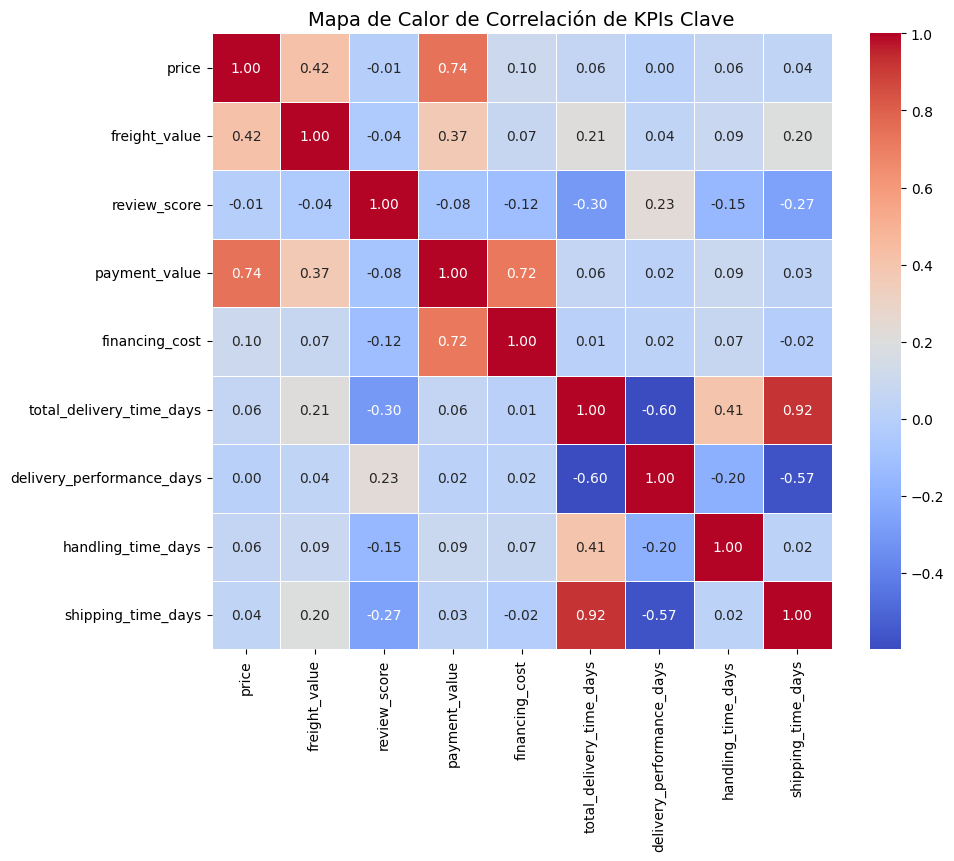

In [ ]:
# Análisis de Dispersión y Correlación

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definir las columnas clave para el análisis de correlación
# Incluye las métricas que se han creado y las métricas de negocio
columnas_correlacion = [
    'price',
    'freight_value',
    'review_score',
    'payment_value',
    'financing_cost',
    'total_delivery_time_days',
    'delivery_performance_days',
    'handling_time_days',
    'shipping_time_days']

# 2. Calcular la matriz de correlación de Pearson
matriz_correlacion = df_fact_sales[columnas_correlacion].corr(method='pearson')

# 3. Visualizar el Mapa de Calor
plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_correlacion,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar=True)

plt.title('Mapa de Calor de Correlación de KPIs Clave', fontsize=14)
plt.show()

#### 4.6.2 **Conclusión sobre la Estructura de Costos**
Se confirma la hipótesis de que los intereses de financiación (financing_cost) son un componente significativo del valor total de la orden. La correlación entre financing_cost y el payment_value es fuertemente positiva (r=+0.72), lo cual sugiere que los clientes optan por financiación en pedidos de mayor valor.



**Resumen Ejecutivo Operacional**

El análisis confirma que el foco de la mejora operacional y la retención de clientes debe situarse en la gestión y optimización de la red de transportistas. El rendimiento interno (handling_time_days) es comparativamente eficiente, mientras que el shipping impacta directamente en la satisfacción del cliente.

### **4.7 Análisis de Sentimiento**
Esta sección utiliza el análisis de correlación y el procesamiento de lenguaje natural (NLP) para obtener conclusiones profundas sobre la satisfacción del cliente (review_score) y las causas raíz de la insatisfacción.


#### **4.7.1 Corroboración y Discrepancia del Sentimiento VADER**
Para validar la técnica de NLP, se comparó la puntuación numérica del cliente (review_score) con el score de sentimiento generado por el modelo VADER (vader_score).


* **Validación Visual:** El gráfico de barras confirma que el Score 5 es el único con un sentimiento promedio positivo, mientras que las puntuaciones de 1 a 4 son negativas o cercanas a cero.
* **Correlación:** La correlación entre la puntuación numérica y el vader_score resultó ser muy débil (r=0.14).
* **Conclusión de la Discrepancia:** Esta baja correlación es un insight clave: el modelo VADER no está optimizado para el idioma portugués, lo que lleva a clasificar erróneamente comentarios positivos como neutrales (r≈0.00). Esto demuestra que la review_score numérica y el análisis de frecuencia de palabras son las herramientas más fiables para la toma de decisiones en este proyecto.

In [ ]:
# Instalación y Preparación de Datos para NLP

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

nltk.download('vader_lexicon', quiet=True)

# 1. Unir la tabla de reviews con la tabla de hechos para obtener la fecha y el score numérico.
df_reviews_nlp = pd.merge(
    df_fact_reviews[['order_id', 'review_comment_message', 'review_score']],
    df_fact_sales[['order_id', 'order_purchase_timestamp']],
    on='order_id',
    how='inner')

# 2. Limpieza de Texto: Seleccionar solo las reseñas que tienen texto
df_reviews_nlp.dropna(subset=['review_comment_message'], inplace=True)
df_reviews_nlp['review_comment_message_clean'] = df_reviews_nlp['review_comment_message'].astype(str).str.lower()

# 3. Análisis de Sentimiento VADER
sia = SentimentIntensityAnalyzer()

# Función para obtener el score compuesto de VADER
# Se añade una limpieza simple para manejar caracteres no estándar antes de pasar a VADER
def get_vader_score(text):
    text_cleaned = re.sub(r'[^\w\s\.\,\!\?]', '', text)
    return sia.polarity_scores(text_cleaned)['compound']

# Aplicar la función a la columna de texto limpio
df_reviews_nlp['vader_score'] = df_reviews_nlp['review_comment_message_clean'].apply(get_vader_score)

print("--- Análisis de Sentimiento VADER Completado. Muestra de validación: ---")
print(df_reviews_nlp[['review_score', 'vader_score', 'review_comment_message_clean']].sample(5))

--- Análisis de Sentimiento VADER Completado. Muestra de validación: ---
        review_score  vader_score  \
22066              3       0.0000   
96527              5       0.0000   
3860               1       0.0000   
116685             5       0.5994   
20943              3      -0.2960   

                             review_comment_message_clean  
22066   sei que não é culpa do produtor, mas essa capi...  
96527                     foi de acordo como eu esperava.  
3860    comprei um ultrabook e foi enviado um celular,...  
116685  a forma de pagamento super fácil, e o produto ...  
20943   a loja sim , mais o site me deixou a desejar p...  


/tmp/ipython-input-174788936.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_mensual = df_reviews_nlp['vader_score'].resample('M').mean()


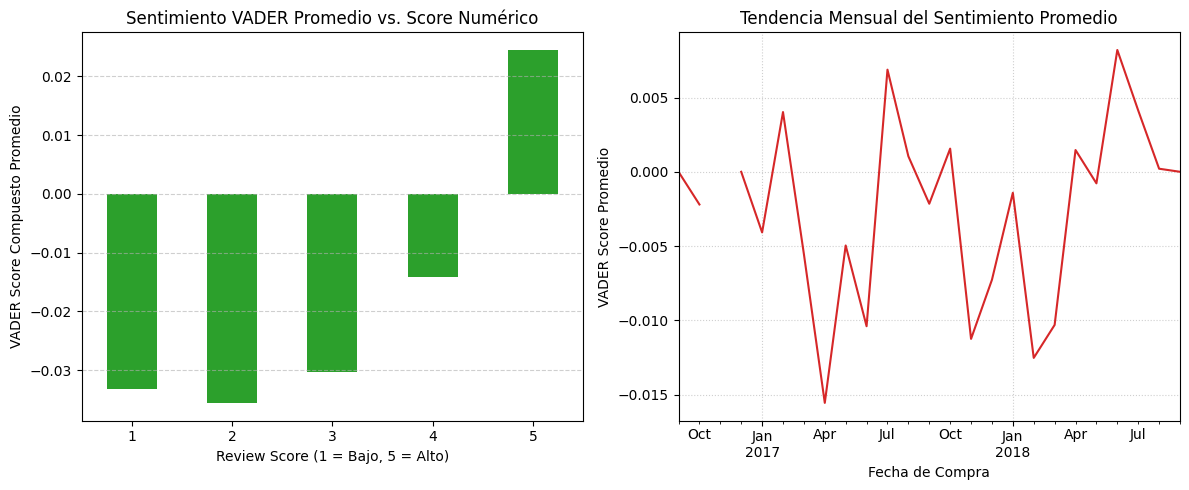


Correlación entre Review Score Numérica y VADER Score: 0.14


In [ ]:
# Corroboración de Sentimiento

# Gráfica de la media de vader_score por cada review_score (1 a 5)
plt.figure(figsize=(12, 5))

# Subplot 1: Gráfico de Barras para Corroboración (Sentiment por Review Score)
plt.subplot(1, 2, 1)
df_reviews_nlp.groupby('review_score')['vader_score'].mean().plot(kind='bar', color='tab:green')
plt.title('Sentimiento VADER Promedio vs. Score Numérico')
plt.xlabel('Review Score (1 = Bajo, 5 = Alto)')
plt.ylabel('VADER Score Compuesto Promedio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Subplot 2: Serie Temporal del Sentimiento
if 'order_purchase_timestamp' in df_reviews_nlp.columns:
    df_reviews_nlp.set_index('order_purchase_timestamp', inplace=True)
sentiment_mensual = df_reviews_nlp['vader_score'].resample('M').mean()

plt.subplot(1, 2, 2)
sentiment_mensual.plot(kind='line', linestyle='-', color='tab:red')
plt.title('Tendencia Mensual del Sentimiento Promedio')
plt.xlabel('Fecha de Compra')
plt.ylabel('VADER Score Promedio')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# Calcular la Correlación
final_corr = df_reviews_nlp['review_score'].corr(df_reviews_nlp['vader_score'])
print(f"\nCorrelación entre Review Score Numérica y VADER Score: {final_corr:.2f}")

#### **4.7.2 Análisis de Frecuencia de Palabras Clave (Topic Modeling)**
Se utilizó el Análisis de Frecuencia de Palabras para realizar un Topic Modeling simple, identificando las causas raíz de la insatisfacción y el contexto cualitativo detrás de las reseñas. Esta técnica es más fiable que el VADER Score para el portugués, ya que no depende de la calibración lingüística.

A. Distinción entre Insatisfacción Crítica (1/2) y Moderada (3)
El análisis de frecuencia reveló una diferencia fundamental en la naturaleza de la queja entre la insatisfacción crítica (Scores 1 y 2) y la insatisfacción moderada (Score 3).

1. Insatisfacción Crítica (Score 1 y 2): Fallo Total del Servicio
Esta categoría está dominada por la falla total de entrega y la ausencia de soporte. Palabras como recebi (recibí) y ainda (todavía) son muy frecuentes, indicando que el problema principal es la pérdida o falta de entrega del pedido, lo cual es más grave que un simple retraso. Además, la existencia de las palabras contato (contacto), nota (aviso) y nada (nada) en el top 20 de palabras repetidas en estas reviews pueden sugerir fallas en el servicio al cliente y la falta de entrega del pedido o de la contestación de los problemas por parte de la empresa.

2. Insatisfacción Moderada (Score 3): Objeción y Calidad Mitigada
La naturaleza de esta queja es más de objeción que de pérdida. La frecuencia de la palabra prazo (plazo) es mayor que la de "no", sugiriendo que el pedido, aunque con retraso, llega en más casos. La inclusión de la palabra porém (pero) como novena palabra más repetida sugiere que aunque el servicio fue aceptable o correcto, el cliente pone una objeción negativa validando que esta categoría entra en el rango de calidad mitigada, donde el cliente expresa que el servicio fue aceptable pero con un detalle negativo que le impide otorgar un 4 o 5.

B. Explicación de la Anomalía (Score 4)
El Score 4 se explica por una satisfacción mitigada o una experiencia de "casi perfecta".

Las palabras frecuentes como prazo, entrega y bom (bueno) confirman que la logística general y la calidad del artículo fueron aceptables, satisfaciendo la expectativa principal del cliente.

La causa de la resta de puntos se infiere por la presencia de la palabra porém (pero), un conector que introduce una objeción menor. El cliente está diciendo: "La experiencia fue buena, pero [hubo un detalle que restó un punto]". Esta insatisfacción no es con el servicio principal, sino con un error menor o una expectativa no cubierta que capturó el VADER Score negativo.




In [ ]:
# Preparación para Conteo de Frecuencias
from nltk.corpus import stopwords
from collections import Counter
import string

# Descargar la lista de stopwords en portugués (si no la tienes)
nltk.download('stopwords', quiet=True)

# Definir las stopwords
stop_words = set(stopwords.words('portuguese'))
# Añadir palabras de limpieza adicionales
stop_words.update(['olist', 'produto', 'pedido', 'compra', 'entregue', 'aqui'])

In [ ]:
# Conteo de Palabras Clave

# 1. Función para limpiar y extraer palabras
def extract_words(text):
    # Remover puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Separar en palabras y convertirlas a minúsculas
    words = text.lower().split()
    # Filtrar stopwords y palabras de menos de 3 letras
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words

# 2. Centrarse en comentarios negativos (Score 1 y 2)
# Concatenar todos los mensajes en un solo texto
negative_reviews = ' '.join(
    df_reviews_nlp[df_reviews_nlp['review_score'].isin([1, 2])]['review_comment_message_clean'])
negative_words = extract_words(negative_reviews)
negative_top_20 = Counter(negative_words).most_common(20)

# 3. Centrarse en comentarios de TRANSICIÓN (Score 3)
score_3_reviews = ' '.join(
    df_reviews_nlp[df_reviews_nlp['review_score'] == 3]['review_comment_message_clean'])
score_3_words = extract_words(score_3_reviews)
score_3_top_20 = Counter(score_3_words).most_common(20)

# 4. Centrarse en comentarios de ANOMALÍA (Score 4)
score_4_reviews = ' '.join(
    df_reviews_nlp[df_reviews_nlp['review_score'] == 4]['review_comment_message_clean'])
score_4_words = extract_words(score_4_reviews)
score_4_top_20 = Counter(score_4_words).most_common(20)

print("\n--- TOP 20 Palabras en Reviews Negativas (Score 1 y 2) ---")
print(negative_top_20)
print("\n--- TOP 20 Palabras en Reviews Negativas (Score 3) ---")
print(score_3_top_20)
print("\n--- TOP 20 Palabras en Reviews de ANOMALÍA (Score 4) ---")
print(score_4_top_20)


--- TOP 20 Palabras en Reviews Negativas (Score 1 y 2) ---
[('recebi', 4908), ('comprei', 3059), ('veio', 2200), ('ainda', 1808), ('entrega', 1704), ('chegou', 1606), ('apenas', 1216), ('nao', 1215), ('produtos', 1015), ('prazo', 997), ('dia', 983), ('dois', 964), ('loja', 942), ('agora', 877), ('contato', 698), ('site', 676), ('duas', 657), ('pois', 647), ('nota', 635), ('nada', 634)]

--- TOP 20 Palabras en Reviews Negativas (Score 3) ---
[('recebi', 878), ('veio', 679), ('entrega', 563), ('prazo', 533), ('comprei', 503), ('bom', 455), ('chegou', 439), ('ainda', 388), ('porém', 287), ('apenas', 283), ('nao', 252), ('produtos', 245), ('bem', 241), ('gostei', 221), ('loja', 216), ('qualidade', 209), ('dia', 204), ('antes', 179), ('frete', 175), ('pois', 175)]

--- TOP 20 Palabras en Reviews de ANOMALÍA (Score 4) ---
[('prazo', 1574), ('bom', 1202), ('entrega', 1104), ('chegou', 897), ('antes', 862), ('recomendo', 611), ('tudo', 557), ('bem', 555), ('recebi', 552), ('veio', 544), ('qua

#### **4.7.3 Conclusión Estratégica de la Fase Python**
La fase de Feature Engineering y EDA arroja dos conclusiones estratégicas fundamentales para la dirección de Olist:

Prioridad Logística: La insatisfacción está impulsada por el tiempo de envío del transportista (r=−0.27 con review_score) y los fallos de entrega total (palabra clave: recebi). La inversión operativa debe centrarse en el rendimiento de los carriers y la gestión de la última milla.

Soporte al Cliente: Existe una brecha en el servicio al cliente, ya que los clientes recurren al comentario público (contato, site) para expresar frustración por no obtener información sobre pedidos fallidos.

## **5. Fase de visualización (Power BI)**
En esta parte se ha utilizado Power BI para la visualización de los datos con el fin de consolidar la información obtenida durante todo el proceso y permitir que la directiva tome decisiones útiles y basadas en datos que permitan la optimización del negocio.

### **5.1 Exportación de Tablas Finales**
El Dataframe principal (df_reviews_nlp) se dividió y exportó en las siguientes seis tablas, que conforman el esquema dimensional para la visualización en Power BI.

In [ ]:
# Exportación de Datos a CSV

export_path = '/content/'

# Tablas a exportar
tables_to_export = {
    'fact_sales_final': df_fact_sales,
    'dim_customer_final': df_dim_customer,
    'dim_seller_final': df_dim_seller,
    'dim_product_final': df_dim_product,
    'dim_time_final': df_dim_time,
    'fact_reviews_final': df_fact_reviews}

print("--- Iniciando Exportación de Tablas a CSV ---")
for name, df in tables_to_export.items():
    file_name = export_path + name + '.csv'
    # Exportar sin el índice de Pandas (index=False)
    df.to_csv(file_name, index=False, encoding='utf-8')
    print(f"Exportado: {name}.csv ({len(df)} filas)")

print("\n Exportación completada.")

--- Iniciando Exportación de Tablas a CSV ---
Exportado: fact_sales_final.csv (118307 filas)
Exportado: dim_customer_final.csv (99163 filas)
Exportado: dim_seller_final.csv (3088 filas)
Exportado: dim_product_final.csv (32951 filas)
Exportado: dim_time_final.csv (615 filas)
Exportado: fact_reviews_final.csv (99224 filas)

 Exportación completada.


### **5.2 Resumen de Transformaciones en Power Query**
Las siguientes transformaciones se aplicaron en el Editor de Power Query (Transform Data) para corregir inconsistencias y errores de datos, optimizando el modelo antes de la carga final.

**A. Limpieza de la Tabla de Hechos (fact_sales_final)**

**Valores Monetarios:** Se corrigió el problema del separador decimal (el Locale) que leía 0.85 como 85. Se eliminaron los pasos de tipo de dato erróneos y se forzó la conversión a Decimal Number después de establecer el Locale de lectura correcto.

Columnas Afectadas: price, freight_value, payment_value, etc.
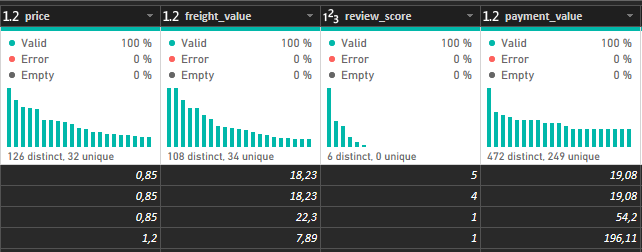

**Tipos de Datos Operacionales (KPIs):** Las columnas de tiempo de envío y handling (delivery_time_days, shipping_time_days, etc.) se corrigieron de formatos numéricos incorrectos a Decimal Number (o Fixed Decimal Number), lo que permitió que valores como 100 se leyeran correctamente como 10 (ajuste por Locale).

**Fechas:** Todas las columnas de fecha y hora (order_purchase_timestamp, order_delivered_customer_date, etc.) se establecieron al tipo Date/Time para conservar la precisión horaria.

**B. Limpieza de las Dimensiones de Producto**

**dim_product_final (Productos):** Se gestionaron los valores nulos (null) en las categorías para evitar la pérdida de datos de ventas.

**Acción:** Los valores nulos en product_category_name, product_category_name_english y product_photos_qty (61% de las filas) se sustituyeron por la etiqueta Uncategorized (Sin Categorizar). Esto convierte un error de catálogo en un segmento de negocio mapeable.
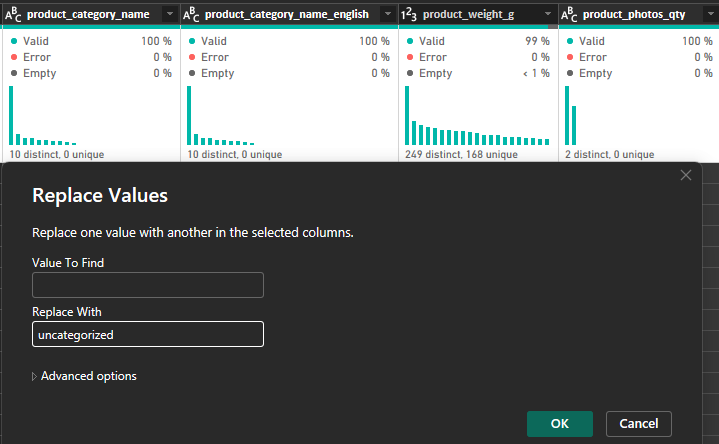

**C. Limpieza de las Dimensiones Geográficas y de Vendedor**

**dim_customer_final y dim_seller_final (Geolocalización):**

**Hallazgo:** Se detectó una corrupción total en las coordenadas geográficas de origen. Los valores atípicos se presentaban en notación científica con magnitudes geográficamente imposibles (ej. −9.97×10
14
 ).

**Proceso de Limpieza:** Se aplicó una Columna Condicional en Power Query, basada en el rango geográfico válido, para aislar y convertir a null cualquier valor irrazonable.

**Resultado:** El 100% de las filas resultaron en nulls, confirmando la inviabilidad de estos datos para el mapeo. Las columnas originales se eliminaron del modelo final. El análisis geográfico se limitará al nivel de Ciudad y Estado.

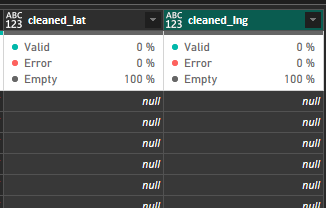




#### **C.1 Lógica M (Power Query) para la Limpieza Geográfica**
Se inserta el código M subyacente de las columnas condicionales que se usaron para validar y convertir a nulo los datos de coordenadas antes de su eliminación final.

In [ ]:
# Lógica M utilizada en la Columna Condicional de Power Query (geolocation_lat)

# Columna: cleaned_lat
# Propósito: Convertir a 'null' todos los valores fuera del rango geográfico [-90, +90]

lat_code = """
if [geolocation_lat] < -90 then null
else if [geolocation_lat] > 90 then null
else [geolocation_lat]
"""

# Columna: cleaned_lng
# Propósito: Convertir a 'null' todos los valores fuera del rango geográfico [-180, +180]

lng_code = """
if [geolocation_lng] < -180 then null
else if [geolocation_lng] > 180 then null
else [geolocation_lng]
"""

print("--- Lógica M (Power Query) Documentada ---")

### **5.3 Modelado de Datos**
Tras la limpieza en Power Query, se procedió a la creación del Modelo Dimensional (Esquema Estrella) en Power BI. Este modelo optimiza el rendimiento y asegura la propagación de filtros para los cálculos DAX.

#### **5.3.1 Creación de Claves de Unión y Limpieza de Dimensiones**
Previo al establecimiento de relaciones, se realizaron ajustes finales en Power Query:

**1. Creación de la Clave de Fecha en fact_sales_final:** La columna order_purchase_timestamp se transformó en la clave numérica order_purchase_date_key (formato YYYYMMDD) para unirse a la dimensión de tiempo, evitando la unión por el número serial de Excel. Esto se hizo mediante las funciones Date.ToText([Columna], "yyyyMMdd") y posterior conversión a Whole Number.

**2. Eliminación de Duplicados:**  Se eliminaron duplicados en las claves de las dimensiones para asegurar la cardinalidad 1 en el lado de la dimensión.

* dim_customer_final: Eliminación de duplicados en customer_unique_id.
* fact_reviews_final: Eliminación de duplicados en order_id para establecer una relación 1:1 con la tabla de hechos.


#### **5.3.2 Esquema Estrella y Cardinalidad**
El modelado en Power BI implementa un Esquema Estrella funcional y optimizado para el análisis de rendimiento de Olist, con la tabla de hechos fact_sales_final como núcleo. El objetivo es asegurar que los filtros fluyan correctamente desde la dimensión (1) hacia la tabla de hechos (∗).

**Relaciones de Dimensión a Hechos (1→∗)**
Las siguientes dimensiones se unen a fact_sales_final con una cardinalidad de Uno a Muchos:


* dim_customer_final:
  - Clave: customer_unique_id
* dim_seller_final:
  - Clave: seller_id
* dim_product_final:
  - Clave: product_id
* dim_time_final:
  - Clave: date_id ↔ order_purchase_date_key (Unión de clave numérica YYYYMMDD)

Relación de Hechos (Satisfacción por Pedido)
* Relación: fact_reviews_final ↔ fact_sales_final
* Clave: order_id
* Cardinalidad: 1↔1 (Bidireccional)
* Justificación: Esta relación de uno a uno se estableció para vincular directamente el Review Score con las métricas de venta (precio, flete) en el mismo contexto de filtro, facilitando el análisis de correlación y causa raíz de la satisfacción del cliente.

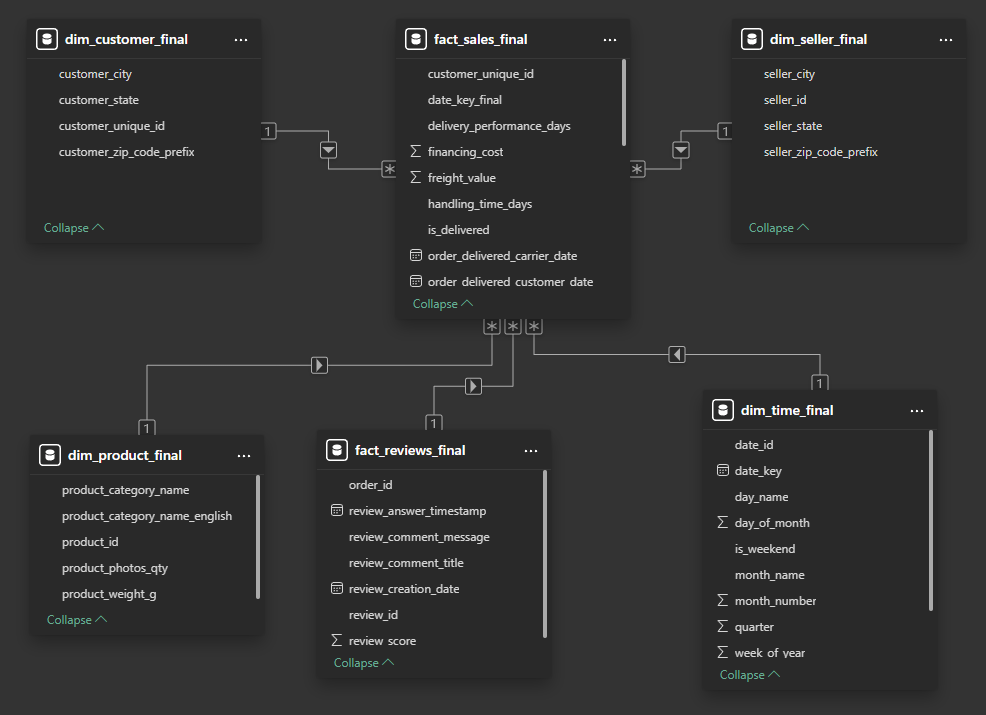


#### **5.3.3 Optimización de Dimensiones: Propiedades, Jerarquías y Visibilidad**
La optimización de las dimensiones se realizó para mejorar la usabilidad y la experiencia del usuario final, asegurando que las búsquedas, filtros y análisis de drill-down funcionen de forma lógica.

**A. Configuración de Propiedades Clave (Key Column y Row Label)**

Se asignaron los identificadores únicos y etiquetas descriptivas a cada dimensión. Las tablas de hechos se dejaron sin estas propiedades, ya que se rigen por la clave compuesta.

* **dim_customer_final:**

  - Key Column: customer_unique_id

  - Row Label: customer_city

* **dim_seller_final:**

  - Key Column: seller_id

  - Row Label: seller_city

* **dim_product_final:**

  - Key Column: product_id
  
  - Row Label: product_category_name

* **dim_time_final:**

  - Key Column: date_id (Clave numérica YYYYMMDD)

  - Row Label: date_key (Formato de fecha legible)

* **Tablas de Hechos (fact_sales_final, fact_reviews_final):**

  - Ambas se dejaron con Key Column y Row Label en blanco, ya que no representan entidades únicas.

  - Nota: La Key Column de fact_reviews_final se definió como review_id tras la eliminación de duplicados para asegurar la unicidad.

**B. Creación de Jerarquías para Análisis de Drill-Down**

Se crearon jerarquías lógicas para facilitar el análisis de tendencias y la exploración geográfica en el dashboard.

**1. Jerarquía Geográfica (Cliente y Vendedor)**
Se configuró el orden de Menos Granular → Más Granular para el análisis geográfico de rendimiento:

* dim_customer_final: customer_state → customer_city → customer_zip_code_prefix.

* dim_seller_final: seller_state → seller_city → seller_zip_code_prefix.

**2. Jerarquía Temporal (Tendencias)**
Se reordenó la jerarquía de tiempo para priorizar el análisis de tendencia de largo plazo sobre el detalle diario:

* dim_time_final: year → quarter → month_name → date_key.

Nota: El campo day_name se excluyó de la jerarquía principal, ya que es un atributo de comportamiento y no de tendencia.

**C. Gestión de Visibilidad (Ocultar Columnas)**

Todas las claves foráneas, claves primarias y datos crudos que no se utilizan en la visualización o las medidas DAX finales se marcaron como ocultas (Is Hidden: Yes). Esto se hizo para simplificar la vista de campos del informe y prevenir el uso accidental de columnas sin agregar.


**Columnas Ocultas por Categoría:**

**1. Claves de Unión (Primary/Foreign Keys):**

  - customer_unique_id, seller_id, product_id, order_id, review_id, date_id (clave numérica del tiempo).

**2. Datos Crudos/Duplicados:**

  - order_purchase_timestamp (reemplazada por la clave de fecha limpia).

  - review_comment_title, review_comment_message (texto crudo en portugués).

  - product_category_name (reemplazada por la versión en inglés, si existe, o por la columna que se mantiene visible).

**D. Categorización de Datos Geográficos**

Se aplicó la propiedad de Data Category a las columnas de ubicación para mejorar la funcionalidad de los visuales de mapa:

  - *_city → City

  - *_state → State or Province

  - *_zip_code_prefix → Postal Code

Nota: Se confirmó que la categoría Latitude/Longitude no era viable para las columnas geográficas corruptas y que la eliminación de dichos campos fue la acción correcta.


### **5.4 Documentación de KPIs del Modelo de Datos**

Este documento detalla las Medidas DAX (Key Performance Indicators) finales implementadas en el modelo de Power BI sobre la base de datos Olist. Estas métricas han sido optimizadas para la precisión del cálculo, la robustez ante outliers de datos y el flujo de filtro.

#### **1. KPIs de Recurrencia y Volumen (Base)**

*   **total\_orders:**
    *   `DISTINCTCOUNT('fact_sales_final'[order_id])`
    *   Mide el volumen total de transacciones únicas. Es el denominador base para todos los KPIs de porcentaje logístico y reviews.
*   **total\_price:**
    *   `SUM('fact_sales_final'[price])`
    *   Ingresos totales generados por el valor de los productos vendidos (sin flete ni financiación).
*   **total\_customers:**
    *   `DISTINCTCOUNT(dim_customer_final[customer_unique_id])`
    *   Cuenta el universo total de clientes únicos.
*   **total\_sellers:**
    *   `DISTINCTCOUNT(dim_seller_final[seller_id])`
    *   Cuenta el universo total de vendedores únicos.
*   **avg\_items\_per\_order:**
    *   `AVERAGEX(VALUES('fact_sales_final'[order_id]), COUNTROWS('fact_sales_final'))`
    *   Cantidad promedio de ítems incluidos por pedido.

#### **2. KPIs Financieros (Ingresos, Costos y Márgenes)**

Estos KPIs provienen de las variables de costo y valor en la tabla fact\_sales\_final.

*   **total\_revenues:**
    *   `SUM(′fact_sales_final′ [payment_value])`
    *   Ingreso Total. Suma de todo lo pagado por el cliente (producto, flete e intereses de financiación).
*   **total\_freight:**
    *   `SUM(′fact_sales_final′ [freight_value])`
    *   Costo o valor total de los servicios de flete cobrados al cliente.
*   **financing\_profit:**
    *   `[total_revenues]−[total_price]−[total_freight]`
    *   Ingresos por Financiación. El monto extra pagado por el cliente por intereses de financiación.
*   **operating\_profit:**
    *   `[total_price]−[total_freight]`
    *   Beneficio Operacional. El valor del producto menos el costo del flete.
*   **financing\_margin:**
    *   `DIVIDE([financing_profit],[total_revenues])`
    *   Porcentaje de los ingresos totales que provienen de la financiación.
*   **operating\_margin:**
    *   `DIVIDE([operating_profit],[total_price])`
    *   Margen Operacional como porcentaje del precio base del producto.

#### **3. KPIs de Tiempos Operacionales (Corregidos con Filtrado de Outliers)**

Para asegurar la precisión de los promedios, se utiliza AVERAGEX con filtros explícitos para excluir los errores de registro (outliers) previamente identificados.

*   **avg\_handling\_days:**
    *   `AVERAGEX(FILTER(fact_sales_final,fact_sales_final[handling_time_days]>−5),fact_sales_final[handling_time_days])`
    *   Tiempo promedio de gestión interna. Excluye valores $\le -5$ días, que son errores claros de registro.
*   **avg\_shipping\_days:**
    *   `AVERAGEX(FILTER(fact_sales_final,fact_sales_final[shipping_time_days]>0),fact_sales_final[shipping_time_days])`
    *   Tiempo promedio de envío. Excluye cualquier valor $\le 0$ días.
*   **avg\_total\_delivery\_days:**
    *   `AVERAGEX(FILTER(fact_sales_final,fact_sales_final[total_delivery_time_days]>0),fact_sales_final[total_delivery_time_days])`
    *   Tiempo total de entrega. Excluye cualquier valor $\le 0$ días.
*   **avg\_performance\_delivery\_days:**
    *   `AVERAGEX(FILTER(fact_sales_final,fact_sales_final[delivery_performance_days]>−10),fact_sales_final[delivery_performance_days])`
    *   Margen de buffer (Días estimados - Días reales). Mide la eficiencia logística frente al SLA.

#### **4. KPIs de Calidad Operacional y Lealtad**

*   **loyal\_customers:**
    *   Condición: Clientes con `DISTINCTCOUNT(order_id) > 1`
    *   Clientes Leales/Recurrentes (clientes con más de un pedido en el contexto anual).
*   **avg\_review\_score:**
    *   `CALCULATE(AVERAGE(...), USERELATIONSHIP(dim_time_final, fact_reviews_final))`
    *   Puntuación promedio de las reseñas. Filtra por la fecha de la reseña usando USERELATIONSHIP.
*   **reviews\_percentage:**
    *   `DIVIDE([Total Reviews], [Total Orders])`
    *   Tasa de feedback. Porcentaje de pedidos que reciben una reseña.

#### **5. KPIs de Rendimiento de Entrega (Clasificación Final)**

Estas métricas utilizan pedidos únicos y se basan en la columna calculada Delivery\_Status\_Category para asegurar la exclusión mutua y el correcto filtrado en el dashboard.

*   **on\_time\_delivery:**
    *   `CALCULATE(DISTINCTCOUNT(fact_sales_final[order_id]), ...)`
    *   Conteo de pedidos entregados a tiempo. Usado como numerador para on\_time\_delivery\_perc.
*   **late\_delivery\_orders:**
    *   `CALCULATE(DISTINCTCOUNT(fact_sales_final[order_id]), ...)`
    *   Conteo de pedidos entregados tarde. Usado como numerador para late\_delivery\_perc.
*   **undelivered\_orders:**
    *   `CALCULATE(DISTINCTCOUNT(fact_sales_final[order_id]), ...)`
    *   Conteo de pedidos fallidos/cancelados. Usado como numerador para undelivered\_perc.
*   **on\_time\_delivery\_perc:**
    *   `DIVIDE([on_time_delivery], [Total Orders])`
    *   Tasa de Éxito. Porcentaje de pedidos entregados a tiempo.
*   **late\_delivery\_perc:**
    *   `DIVIDE([late_delivery_orders], [Total Orders])`
    *   Tasa de Retraso. Porcentaje de pedidos entregados tarde.
*   **undelivered\_perc:**
    *   `DIVIDE([undelivered_orders], [Total Orders])`
    *   Tasa de Fallo. Porcentaje de pedidos fallidos.
*   **Columna Clave para Filtrado (No es un KPI):**
    *   `Delivery_Status_Category`
    *   Columna Calculada IF/VAR en fact\_sales\_final
    *   Clasifica cada pedido como 'On Time Delieveries', 'Late Deliveries' o 'Undelivered'. Es la dimensión utilizada en el Slicer para filtrar todos los gráficos del dashboard.

### **5.5 Documentación de los Dashboards e Insights**

#### **5.5.1 Rendimiento Financiero (Financial Performance)**

El análisis del rendimiento financiero revela una tendencia robusta de crecimiento de ingresos con una eficiencia de costes estable, al tiempo que identifica claras oportunidades de optimización en la gestión operativa y en la priorización de pedidos con bajo margen.

##### **1. Crecimiento, Estabilidad y Eficiencia del Margen**

*   **Hallazgo Clave:**
    *   **Crecimiento de Ingresos Sostenido:** La trayectoria del marketplace es altamente positiva, con un crecimiento interanual (Y-o-Y) superior al 20%, a pesar de la ausencia de datos en los últimos cuatro meses de 2018.
    *   **Estabilidad del Margen Operativo:** El Margen Operativo se mantuvo estable durante todo el período de crecimiento de ingresos. Esto es un indicador de la eficiencia y escalabilidad del modelo de costes, asegurando que el aumento de las ventas se traduce directamente en un incremento lineal del beneficio operativo.

##### **2. Tendencias y Rentabilidad por Categoría de Producto**

El portafolio de productos ha mostrado una evolución positiva hacia categorías de mayor rentabilidad.

*   **Dominio Tradicional (2017):** Las categorías líderes en ingresos fueron dormitorio y baño, accesorios de ordenador, decoración de cocina y accesorios de deporte.
*   **Aparición de Categorías de Alto Margen (2018):** Se observa una tendencia positiva con el breakout de salud y belleza ($\text{Rentabilidad} > 85\%$) y relojes ($\text{Rentabilidad} > 91\%$). Estas categorías representan la mayor oportunidad para el crecimiento del margen futuro.
*   **Contradicción Operacional (Salud y Belleza):** A pesar del gran volumen de ingresos y las reseñas positivas (4 y 5 puntos), la categoría salud y belleza experimentó un alto número de pedidos no entregados o entregados tarde (especialmente en Q1/2018).
    *   **Conclusión:** Esto sugiere que el producto es de alta calidad y deseable, pero existe un problema en la ejecución logística (preparación o transporte), lo que debe abordarse inmediatamente para no dañar la reputación de las categorías rentables.

##### **3. Impacto Operativo y Correlación con el Rendimiento de la Entrega (2017)**

La correlación entre el crecimiento de la demanda y la capacidad operativa es crítica, especialmente en el cuarto trimestre de 2017.

*   **Sobrecarga Operativa de Q4:** El cuarto trimestre de 2017 fue el de mejor rendimiento en ingresos, pero también el que concentró la mayoría de los pedidos entregados fuera de la fecha estimada (especialmente en noviembre y diciembre). Esto indica una pequeña sobrecarga estacional del sistema logístico.
*   **Concentración de Fallos (Q2 y Decoración/Jardinería):** Los fallos de entrega (pedidos no entregados) se concentraron en el segundo trimestre (abril), ligados a dos categorías:
    *   **Decoración de Cocina:** Aparece en los rankings de ingresos, entregas a tiempo, entregas tardías y fallos, lo que sugiere una gestión operativa inconsistente.
    *   **Herramientas de Jardinería:** Lideran los ingresos de los pedidos no entregados (Fallos de Q2).
    *   **Alerta de Priorización Financiera:** El margen de financiación de las herramientas de jardinería es negativo. Esto podría indicar que, al ser pedidos de bajo valor financiero (o con bonificaciones/descuentos), fueron tratados con menor prioridad operativa, lo que se correlaciona con la alta tasa de fallos de entrega en esa categoría.

##### **4. Hallazgo de Calidad y Riesgo (Puntuación vs. Financiación)**

*   **Riesgo de Margen de Financiación:** Existe una clara correlación negativa entre la calidad del producto percibida y el beneficio de financiación: los productos con peor puntuación de reseñas son los que más margen de financiación generan.
    *   **Implicación:** Esto podría ser un riesgo para la reputación. La percepción del cliente es que está pagando más (intereses o financiación) por productos de menor calidad. Se recomienda investigar si la calidad de los productos de mayor financiación cumple con las expectativas.

#### **5.5.2 Rendimiento Operativo (Operating Performance)**

El análisis operativo muestra una mejora general en la velocidad de la logística (manejo y envío) a lo largo del tiempo. Sin embargo, esta mejora ha sido eclipsada por la reducción de los plazos de entrega estimados (SLA), lo que resulta en un aumento de los pedidos entregados tardíamente. Los transportistas y la fase de envío son identificados como el principal punto de fricción durante los picos de demanda.

##### **1. Desafío Central: Reducción del SLA y Aumento del Retraso**

*   **Hallazgo Clave:**
    *   **Implicación de Negocio**
    *   **Aumento de Entregas Tardías:** La ligera disminución de los pedidos entregados a tiempo, combinada con la reducción de pedidos no entregados, indica un aumento en el porcentaje de pedidos entregados tarde. Esta situación se intensificó en el Q4 de 2017 y Q1 de 2018.
    *   **Performance vs. Estimación (SLA):** La operativa total se ha vuelto más rápida (disminución en Handling Avg y Shipping Avg), pero la media de rendimiento (Performance Avg) ha disminuido (se ha vuelto más negativa). Esto sugiere que la estimación de entrega (SLA) se ha reducido a un ritmo mayor que la mejora de la operativa real, creando una presión innecesaria que resulta en retrasos.

##### **2. Eficiencia Logística y Volatilidad**

*   **Estabilidad Operativa (2017):** Las medias de tiempo (Handling Avg y Shipping Avg) se mantuvieron relativamente estables, aunque mostraron un ligero deterioro (aumento del tiempo) en Noviembre debido al pico de demanda (correlacionado con el dashboard financiero).
*   **Mejora y Volatilidad (2018):** En 2018, las medias operativas mostraron una tendencia general a la baja (mejora de la velocidad). Sin embargo, la métrica Shipping Avg (transporte) se volvió más volátil, con un pico notorio en el primer trimestre, lo que indica que los transportistas son el componente más sensible a los momentos de alta demanda.
*   **Consistencia Semanal:** Es un punto fuerte que la eficacia operativa se mantiene constante entre los días de semana y los fines de semana.

##### **3. Fricción y Causas de la Baja Puntuación**

*   **Transporte, la Causa Raíz de las Malas Reseñas:** El análisis de las reseñas de 1 punto confirma que el retraso o la no llegada es el principal motor de la insatisfacción.
    *   El tiempo medio de preparación (Handling Avg) para estas reseñas es de 4,5 días (solo 1.5 veces el promedio de 3 días), mientras que la media de transporte (Shipping Avg) es de $\approx 14$ días (más de 1.5 veces el promedio de 9 días), confirming que el transporte es el factor dominante del fallo.
*   **Saturación en Entregas Tardías:**
    *   **2017 (Entregas Tardías):** El tiempo de preparación aumentó 2.3 veces la media anual días y el tiempo de transporte aumentó 3 veces la media anual 27 días.
    *   **2018 (Mejora):** El aumento de las medias operativas en momentos de saturación ha mejorado, reduciéndose a 1.9 veces (preparación) y 2.8 veces (transporte). La capacidad de absorción de la demanda ha mejorado entre años, pero el shipping sigue siendo el cuello de botella.

##### **4. Pedidos No Entregados (Fallos)**

*   **Descarte de Problemas de Preparación:** En los pedidos no entregados, el Handling Avg se encuentra solo ligeramente por encima de la media anual, y este deterioro es marginal en 2018.
*   **Refutación de la Prioridad por Margen:** El hecho de que la preparación del pedido no sea el factor principal en los fallos de entrega, y que el deterioro en Handling Avg haya ocurrido en Q1 (mientras que el problema de Jardinería fue en Q2), desmiente la hipótesis del dashboard anterior sobre la despriorización de pedidos por bajo margen.
*   **Nueva Hipótesis:** La no entrega es más probable que se deba a problemas específicos del artículo o del proveedor logístico relacionados con la manipulación o la clasificación de esos artículos (ej. Herramientas de Jardinería) y no un fallo general en la fase inicial de preparación.

#### **5.5.3 Rendimiento de Pedidos (Orders Performance)**

El análisis del rendimiento de pedidos confirma la tendencia de crecimiento del volumen de transacciones, la cual está impulsando directamente el aumento de ingresos, dada la estabilidad de las métricas clave del pedido. El principal punto de riesgo identificado es la complejidad de la entrega en pedidos grandes y variados.

##### **1. Crecimiento del Volumen y Correlación con Ingresos**

*   **Hallazgo Clave**
*   **Implicación de Negocio**
*   **Crecimiento Sostenido del Volumen:** El número total de pedidos (Total Orders) ha aumentado en 2018 respecto a 2017. Este aumento es el principal motor del crecimiento de los ingresos totales.
*   **Estabilidad de la Composición del Pedido:** El precio promedio por pedido (Price Avg) y la cantidad promedio de productos por pedido (Qty. Avg) se han mantenido estables en ambos años.
    *   **Conclusión Financiera:** La estabilidad de las métricas de composición implica que el aumento de ingresos tiene una altísima correlación lineal con el volumen de pedidos, demostrando que el crecimiento se basa en la adquisición o recurrencia, no en la inflación de precios o la venta cruzada significativa.

##### **2. Riesgo Operativo: Complejidad y Calidad**

*   **Correlación Negativa con la Variedad de Productos:** Las peores puntuaciones de reseñas (Baja Calidad) se correlacionan directamente con los pedidos que contienen más productos diferentes (mayor cantidad de artículos únicos por transacción).
*   **Impacto en Entregas Fallidas:** Esta tendencia se confirma al observar que la media de la cantidad de artículos en el pedido es la más alta ($\approx 1.7$) en los pedidos de herramientas de jardinería (la categoría previamente identificada con problemas de no entrega).
    *   **Conclusión:** Los pedidos más grandes y variados son logísticamente más complejos de preparar y entregar, lo que aumenta la probabilidad de errores que resultan en bajas puntuaciones o fallos de entrega.

##### **3. Evolución del Rendimiento de la Entrega (Tendencia Positiva)**

*   **Mejora en Fallos de Entrega (2018):** A pesar del aumento en el volumen de pedidos en 2018, ha habido una disminución notable en los pedidos no entregados (Undelivered Orders).
*   **Estabilidad del Año Actual (2018):** La operativa de pedidos en 2018 se mantiene estable en términos de fallos (pedidos no entregados), lo que indica que las mejoras logísticas implementadas están siendo efectivas para asegurar que las transacciones se completen, aunque el desafío se ha desplazado a la gestión del tiempo (pedidos tarde, como se vio en el Dashboard 2).

#### **5.5.4 Clientes y Vendedores (Customers & Sellers)**

El análisis del ecosistema de Clientes y Vendedores muestra un sólido crecimiento en la base de usuarios y proveedores, lo que indica la expansión de la red de la empresa. Sin embargo, la métrica de Lealtad del Cliente está en declive, presentando el desafío más crítico para la sostenibilidad del negocio.

##### **1. Crecimiento del Ecosistema y Riesgo de Lealtad**

*   **Hallazgo Clave**
*   **Implicación de Negocio**
*   **Crecimiento de la Base de la Red:** Tanto el número total de clientes como de vendedores ha aumentado en 2018 respecto a 2017. Esto indica un enriquecimiento y expansión del ecosistema (la "red" o marketplace).
*   **Declive de la Lealtad:** A pesar del crecimiento de la base total, el porcentaje de clientes leales (Loyal Customers) ha estado decreciendo desde el tercer trimestre de 2017 y se encuentra actualmente en su punto más bajo.
*   **Desafío Principal:** Es imperativo investigar las causas de la falta de recurrencia y las barreras que impiden que los nuevos clientes se conviertan en leales, ya que el crecimiento actual se basa fuertemente en la nueva adquisición, no en la fidelización.

##### **2. Concentración Geográfica y Potencial de Expansión**

*   **Dominio Absoluto de São Paulo (SP):** La mayoría de los clientes y vendedores están concentrados en el estado de São Paulo (SP).
*   **Aumento de la Concentración (2018):** El peso de SP en la generación de ingresos es significativo y aumenta en 2018, consolidándola como la zona económica más crítica.
*   **Oportunidad:** La alta concentración subraya la dependencia de una única región, lo que presenta una clara oportunidad estratégica de expansión y diversificación geográfica hacia otros estados.

##### **3. Correlación Operativa y de Calidad por Estado**

El rendimiento logístico muestra una sensibilidad marcada por el estado del cliente y la densidad de pedidos.

*   **Retrasos de Entrega (RJ y Otros):** Los pedidos entregados tarde (Late Deliveries) tienen un porcentaje más alto en Río de Janeiro (RJ) y en la categoría "Otros".
*   **Fallos de Entrega (SP y RJ):** Los pedidos no entregados (Undelivered Orders) prevalecen en SP (debido al volumen), pero también muestran un porcentaje mayor en RJ en relación a su volumen de pedidos.
*   **Causa Lógica:** Esta distribución es previsible dado que la mayoría de los vendedores se encuentran en SP (lo que aumenta el volumen y por tanto la probabilidad de fallo allí) y RJ es la segunda región más activa con una probable mayor distancia logística a SP.

##### **4. Datos de Comportamiento del Cliente Leal**

*   **Comportamiento de Compra:** Los clientes leales tienden a realizar sus pedidos durante los días de semana.
*   **Comportamiento de Reseñas:** La mayoría de los clientes leales otorgan una puntuación de 5 puntos o dejan la reseña en blanco, lo que sugiere que cuando el cliente está satisfecho o tiene una experiencia fluida, su probabilidad de reiterar la compra es alta.

#### **5.5.5 Reseñas, Productos y Estados (Reviews, Products & States)**

El análisis de reseñas destaca un alto nivel de participación y satisfacción del cliente, con una tasa de retroalimentación superior al 90%. Los principales hallazgos confirman la dependencia crítica de la calidad de la entrega en la percepción del cliente y la puntuación de la reseña.

##### **1. Calidad, Participación y Eficiencia del Servicio (SLA)**

*   **Hallazgo Clave**
*   **Implicación de Negocio**
*   **Alta Tasa de Participación en Reseñas:** Más del 90% de los clientes publica una reseña de su experiencia, habiendo incluso aumentado en 2018. Esto proporciona una base de datos robusta y suficiente para obtener insights accionables.
*   **Puntuación Promedio Positiva:** La media de la puntuación de las reseñas (Review Score Avg) se mantiene estable en más de 4 puntos (sobre 5), indicando un nivel general de satisfacción del cliente muy positivo.
*   **Eficiencia del SLA (Service Level Agreement):** El tiempo promedio de respuesta de atención al cliente (SLA Average) muestra una correlación inversa positiva con el volumen: en los períodos con más reseñas y pedidos, el equipo de atención al cliente tarda menos tiempo en responder. Esto es un indicador de la eficiencia operativa en el manejo de picos de demanda.

##### **2. Estacionalidad y Correlación Operacional**

*   **Estacionalidad de Reseñas:** Se observa una disminución de reseñas en noviembre. Esto podría deberse a la alta estacionalidad del negocio, con un aumento de clientes puntuales que compran durante fechas señaladas pero no participan en el proceso de feedback post-venta.
*   **Confirmación de la Causa Raíz:** Este dashboard confirma que las reseñas con peores puntuaciones se deben a la entrega tardía o a la no entrega del pedido, reforzando la conclusión del Dashboard Operativo.

##### **3. Mención al Análisis de Texto de Reseñas**

*   **Análisis Profundo de Texto (Análisis Externo):** El análisis de la longitud y el contenido de las reseñas (letras por reseña), realizado previamente en el entorno de Python, mostró que las reseñas más largas y detalladas generalmente corresponden a las puntuaciones más bajas (1 y 2 puntos), lo que indica una alta frustración y dedicación de tiempo por parte del cliente para explicar el fallo. Las reseñas de 5 puntos tienden a ser más cortas o simplemente dejan una puntuación sin comentario.

##### **4. Concentración Geográfica de Reseñas**

*   **Puntuación por Estado (No mencionado explícitamente en los insights pero crucial):** Es importante notar cómo la distribución geográfica de las reseñas de 1 punto se correlaciona con los problemas operativos identificados, especialmente en regiones secundarias (RJ) y en la capital (SP) debido al volumen.

#### **5.6 Conclusiones Ejecutivas (Executive Summary)**

Es un negocio posicionado perfectamente para la expansión nacional, tiene una base de ingresos sólida (que debería usar para crecer vía marketing, vendedores, logística, ...) y gran potencial de extenderse rápidamente a estados o provincias adyacentes.

##### **1. Resumen**
   
*   **Salud Financiera**
    *   El negocio está en una fase de crecimiento de ingresos robusto (>20\% Y-o-Y) con un margen operativo estable. Sin embargo, la rentabilidad futura estará impulsada por categorías de alto margen como Salud y Belleza.
*   **Riesgo Operacional**
    *   El mayor riesgo es la ejecución logística. La mejora en la velocidad operativa está siendo superada por la reducción del SLA, lo que causa un aumento de entregas tardías. Los transportistas son el punto de fricción principal, especialmente para pedidos grandes o variados.
*   **Riesgo de Clientes**
    *   La lealtad del cliente está en declive a pesar del crecimiento en la adquisición, lo que amenaza la sostenibilidad del crecimiento. El principal motor de las peores reseñas es el fallo en la entrega.

##### **2. Recomendaciones Estratégicas**


*   **Logística/Operaciones**
    * Se debe mejorar la operativa en general y sobre todo en cuanto a los pedidos grandes y con productos diversos así como deberse mitigar la volatilidad de los tiempos de entrega de los transportistas (ampliando la red logística o usaando logística de terceros)
    * Esto aumentaría la experiencia del cliente y por ende los clientes leales (la mayoría     de las reseñas de 4 y 5 puntos)
*   **Expansión Geográfica**
    * Las ventas están muy concentradas en SP debido a que los vendedores y clientes son principalmente de esta zona. Esto es excelente, pero el negocio debería extenderse más a otros lugares e intentar capitalizar oportunidades en otras zonas y, por consiguiente, vendedores de otros sitios aumentando su visibilidad fuera de SP.
    * Esto conseguiría dos cosas, protección (cualquier deterioro en SP arrastraría a todo el negocio) y expandirse.
*   **Productos/Ventas**
    *   Capitalizar las categorías de alto margen: Invertir en marketing y optimización de stock para Salud y Belleza y Relojes. Resolver inmediatamente sus fallos de entrega, ya que es la única barrera para su crecimiento.
    *   Estas categorías tienen una rentabilidad entre un 85% y 91%.
*   **Experiencia del Cliente**
    *   Dado que la lealtad está cayendo y que el problema no es el producto sino la entrega, cualquier programa debe recompensar al cliente (ofertas, bonificaciones, tarjetas de puntos acumulables, etc)

